## Geoscience Australia 9s DEM Map of Tasmania

Here we show a workflow for handling the higher resolution (9 arc second) DEM of Tasmania supplied by Geoscience Australia. This has been clipped using gdaltranslate to capture the area of interest and save it as a geotiff file. This has roughly 2.4 million points on the island of Tasmania. This DEM is hydrologically enforced at the outset and therefore serves as a consistency test for the `quagmire` flow algorithms etc. 

In this notebook, we read the original DEM, check it for consistency and (SPOILER !) make a few adjustments to account for peculiarities of the DEM associated with the various dams in the hydro-schemes. 

We then save the processed DEM ... 
(TODO: parallel HDF5 would be better)

### Dependencies

  - `quagmire` 
  - `gdal`     - used to read and write geotiff files
  - `cartopy`  - to produce maps
  - `lavavu`   - for 3D visualisations


In [1]:
import numpy as np
import quagmire
from quagmire import function as fn
from quagmire import tools as meshtools

import gdal

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
file = "data/dem9s-tassie-quagmire.tif"
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
height = band.ReadAsArray()
[cols, rows] = height.shape

left, hres, n0, top, n1, vres  = ds.GetGeoTransform()
right = left+rows*hres
bottom = top+cols*vres
x,y = np.meshgrid(np.arange(left, right, hres), np.arange(top,  bottom, vres))


In [3]:
ds = gdal.Open(file)
ds.GetProjection()

'GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4283"]]'

In [4]:
from scipy.ndimage.filters import gaussian_filter

point_mask =  height > -0.5

#corners
point_mask[0,0] = 1.0
point_mask[0,-1] = 1.0
point_mask[-1,0] = 1.0
point_mask[-1,-1] = 1.0

xs = x[point_mask]
ys = y[point_mask]
heights = 0.001 * height[point_mask]  ## in km 
points = np.column_stack([xs, ys])

submarine = (heights <  0.01 )
subaerial = (heights >= 0.01 )


In [5]:
DM = meshtools.create_DMPlex_from_points(xs, ys, bmask=subaerial)
mesh = quagmire.SurfaceProcessMesh(DM, downhill_neighbours=2)

0 - Delaunay triangulation 14.714163055s
0 - Calculate node weights and area 0.6173241250000032s
0 - Find boundaries 0.047960793000001445s
0 - cKDTree 0.2893822639999968s
0 - Construct neighbour cloud array 6.491648095000002s
0 - Construct rbf weights 1.6597320970000027s


In [6]:
with mesh.deform_topography():
    mesh.topography.data = heights                                                                 

0 - Build downhill matrices 4.189283983000003s
0 - Build upstream areas 20.757618164s


In [7]:
low_points1 = mesh.identify_low_points()
low_point_coords1 = mesh.coords[low_points1] 
print(low_points1.shape)

cumulative_flow_1 = mesh.upstream_integral_fn(mesh.topography).evaluate(mesh)
topography_1 = mesh.topography.data[:]

outflow_points1 = np.unique(np.hstack(( mesh.identify_outflow_points(), mesh.identify_low_points())))
upstream_area1  = mesh.upstream_integral_fn(fn.misc.levelset(mesh.topography, 0.0)).evaluate(mesh)
print(mesh.identify_outflow_points().shape)

(5,)
(1657,)


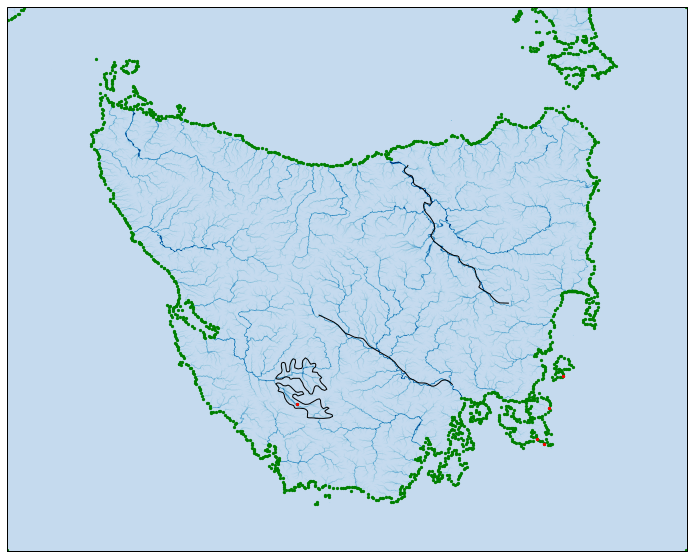

In [8]:
## plot the results

import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                           edgecolor="green",
                           facecolor="blue")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                           edgecolor="green",
                           facecolor="blue")

map_extent = ( left, right, bottom, top)

logflow = np.log10(1.0e-3+upstream_area1)
flows1 = logflow.min() * np.ones_like(height)
flows1[point_mask] = logflow

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

# ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)

ax.add_feature(lakes,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

# ax.scatter(xs[submarine],ys[submarine], color="#000044", s=.1)

plt.imshow(flows1, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=-3.5, vmax=-1.5)

ax.scatter(xs[outflow_points1], ys[outflow_points1], color="Green", s=5)
ax.scatter(xs[low_points1], ys[low_points1], color="Red", s=5)


plt.savefig("WEx4-Flowpath-1.png", dpi=250)

## Apply pit filling / local-flooding / swamp filling algorithm

The pit filling is for very small local minima where the basin filling / swamp algorithm is not appropriate. The local flooding is a simple upward height propagation from a blockage with a limit on the distance that it can propagate. 

The swamp algorithm is for extensive regions that have only internal drainage. Some changes to the identification of "erroneous" low points is needed for cases where internal drainages are expected.

At least one extra round of iteration is often helpful.

In this case, the hydrologically enforced DEM should not have any local minima but there are some issues that are associated with water bodies that are dammed and this does, as a result, need a little modification which we compute here and analyse after the fact. 

In [9]:
# This should not be necessary but there can be some issues with very flat regions not having sufficient relief for the flow directions
# to be recorded.

mesh.low_points_local_patch_fill(its=3, smoothing_steps=1)
topography_2 = mesh.topography.data[:]
cumulative_flow_2 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
low_points2 = mesh.identify_low_points()
low_point_coords2 = mesh.coords[low_points2] 
print("Low points - {}".format(low_points2.shape))


for i in range(0,5):
    mesh.low_points_swamp_fill(ref_height=0.0)
    
    # In parallel, we can't break if ANY processor has work to do (barrier / sync issue)
    low_points3 = mesh.identify_global_low_points()
    
    print("{} : {}".format(i,low_points3[0]))
    if low_points3[0] == 0:
        break
 

Low point local patch fill
0 - Build downhill matrices 4.27715833000002s
0 - Build downhill matrices 3.7353811129999883s
0 - Build downhill matrices 4.062435464999993s
Low point local patch fill  13.359876843999984  seconds
0 - Build upstream areas 20.583038087999995s
Low points - (2,)
879  iterations, time =  21.360739115
Build low point catchments -  21.368196538999996  seconds
0  Sort spills -  0.03126790100000676
0  Gather spill data -  0.0003627930000220658
0  Sort all spills -  6.112700000926452e-05
0 - Build downhill matrices 3.5811703079999972s
Low point swamp fill  25.083112254000014  seconds
0 - Build upstream areas 20.31994342499999s
0 : 10
878  iterations, time =  22.57822705000001
Build low point catchments -  22.586498209000013  seconds
0  Sort spills -  0.03576474499999449
0  Gather spill data -  0.00011437300000238793
0  Sort all spills -  5.9402000005093214e-05
0 - Build downhill matrices 4.375069824999997s
Low point swamp fill  27.121512861000014  seconds
0 - Build up

In [10]:
cumulative_flow_3 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
upstream_area3    = mesh.upstream_integral_fn(fn.misc.levelset(mesh.topography, 0.0)).evaluate(mesh)

low_points3 = mesh.identify_low_points()
topography_3 = mesh.topography.data[:]

print("Low points - {}".format(low_points3.shape))
outflow_points3 = np.unique(np.hstack(( mesh.identify_outflow_points(), mesh.identify_low_points())))


Low points - (0,)


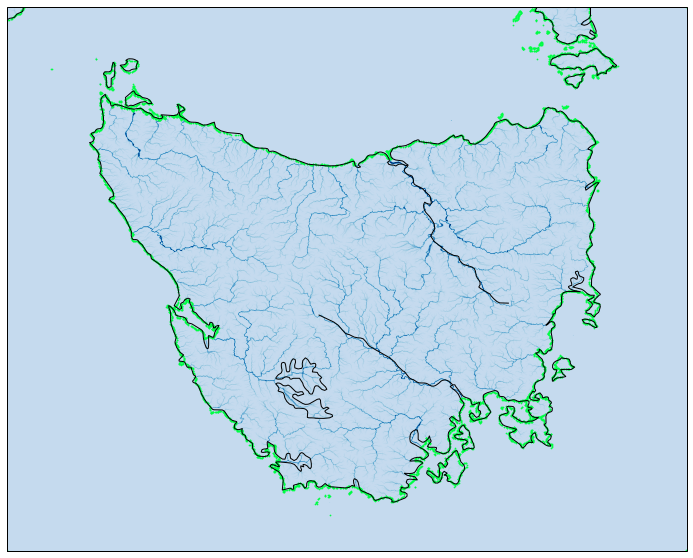

In [11]:
logflow = np.log10(1.0e-3+upstream_area3)
flows3 = logflow.min() * np.ones_like(height)
flows3[point_mask] = logflow

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)


ax.add_feature(coastline,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

ax.scatter(xs[outflow_points3],ys[outflow_points3], color="#00FF44", s=.5, zorder=2)
ax.scatter(xs[low_points3],ys[low_points3], color="#00FF44", s=.5, zorder=3)

plt.imshow(flows3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=-3.5, vmax=-1.5, zorder=1)


In [12]:
## Modify the downhill neighbour connectivity

mesh1 = quagmire.SurfaceProcessMesh(DM, downhill_neighbours=1)
with mesh1.deform_topography():
    mesh1.topography.data = mesh.topography.data 
    


0 - Delaunay triangulation 14.502773720999983s
0 - Calculate node weights and area 0.26116310600002635s
0 - Find boundaries 0.038762957000017195s
0 - cKDTree 0.28722619500001656s
0 - Construct neighbour cloud array 6.6937252110000145s
0 - Construct rbf weights 1.7977227000000084s
0 - Build downhill matrices 3.0404476520000117s
0 - Build upstream areas 17.767726813999957s


<BarContainer object of 6962 artists>

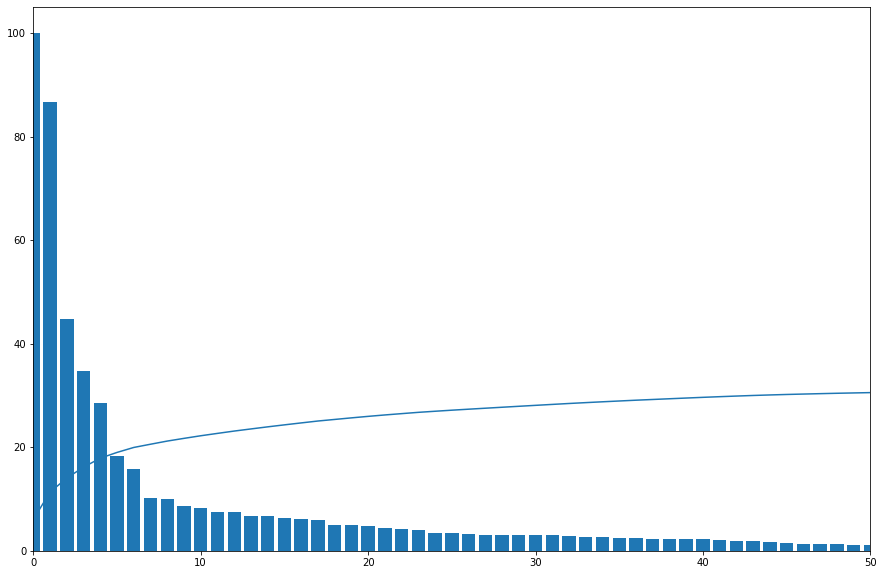

In [14]:
# We want to exclude from the catchments some of the triangles that go to edges or to other islands
# as these really skew the area calculations

topomask = mesh1.add_variable("topomask")
topomask.data = np.where(mesh1.topography.data > 0.001, 1.0, 0.0)

# large triangles associated with boundaries need to be excluded (choose by inspection)
topomask.data = np.where(mesh1.area < 0.01, topomask.data, 0.0)

area = mesh1.upstream_integral_fn(topomask).evaluate(mesh1)

outflow_points3 = np.unique(np.hstack(( mesh1.identify_outflow_points()))) # , mesh1.identify_low_points())))

# log_catchment_areas = np.sort(1.0e-10+np.log(area[outflow_points3]))[::-1]
catchment_areas = np.sort(area[outflow_points3])[::-1]
cum_catchment_areas = np.cumsum(catchment_areas)
total_area = mesh1.area.sum()

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.set_xlim(0,50)
ax.plot(100.0*cum_catchment_areas/total_area)
ax.bar(x=range(0,catchment_areas.shape[0]), height=100.0*catchment_areas/catchment_areas[0])


In [15]:
ordered_catchments = np.argsort(area[outflow_points3])[::-1]
catchments = mesh1.add_variable(name="catchments")
catchments.data = mesh1.uphill_propagation(points = outflow_points3[ordered_catchments[0:100]], values=np.indices((100,)), fill=-1.0, its=1000)

797  iterations, time =  17.401331998000046


In [16]:
catch = []
for i in range(0,outflow_points3.shape[0]):
    catch.append( np.where(catchments.data==i) )

In [17]:
for i in range(0,25):
    print(catch[i][0].shape, area[outflow_points3[ordered_catchments[i]]])

(194062,) 1.2127916666644611
(168190,) 1.0511062499980888
(86902,) 0.5431156249990113
(67228,) 0.42014479166590296
(55497,) 0.3466968749993693
(35609,) 0.2225156249995954
(30640,) 0.19149062499965164
(19967,) 0.12438854166644037
(19527,) 0.12196770833311148
(16835,) 0.10432083333314358
(16100,) 0.10059895833315036
(14642,) 0.09147708333316695
(14382,) 0.0898718749998365
(13102,) 0.08187916666651772
(12894,) 0.08059166666652014
(12312,) 0.0769541666665267
(11982,) 0.07481979166653054
(11726,) 0.07329583333319997
(9800,) 0.06071666666655623
(9718,) 0.06066874999988964
(9313,) 0.05818333333322753
(8721,) 0.0544749999999009
(8119,) 0.050723958333241066
(7983,) 0.04989687499990922
(6762,) 0.04223541666658982


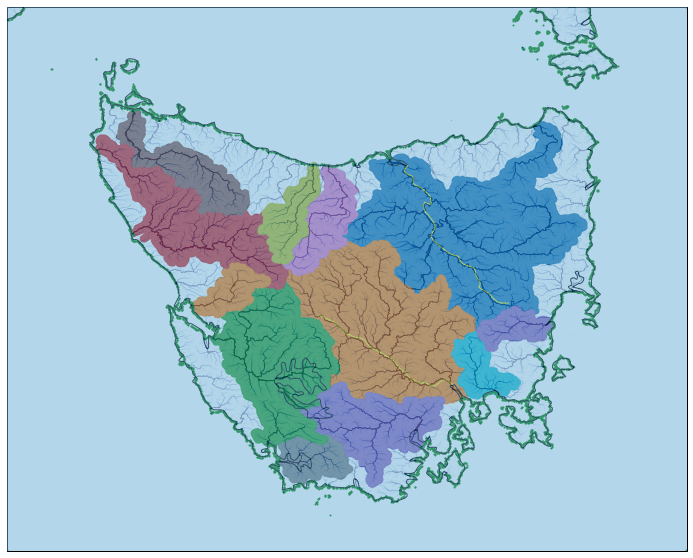

In [18]:
# catch_img3 = -2.0 * np.ones_like(height)
# catch_img3[point_mask] = catchments.data

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="Yellow", facecolor="none", linewidth=1, zorder=3)

for i in range(0,15):
    ax.scatter(xs[catch[i]], ys[catch[i]], s=20, alpha=0.5)

ax.scatter(xs[outflow_points3], ys[outflow_points3], color="Green", s=1.0)
ax.scatter(xs[low_points3],     ys[low_points3], color="Red", s=25.0)

plt.imshow(flows3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=-3.5, vmax=-2.5, alpha=0.5, zorder=10)

plt.savefig("WEx4-15Catchments.png", dpi=250)

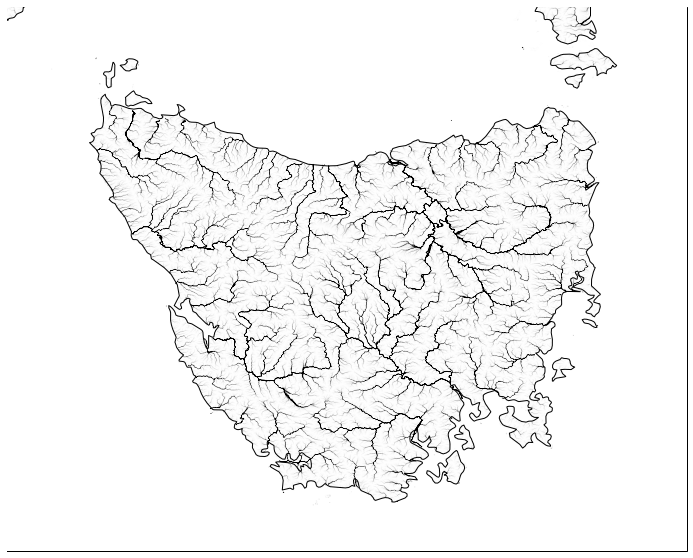

In [19]:
# catch_img3 = -2.0 * np.ones_like(height)
# catch_img3[point_mask] = catchments.data

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=30)

# for i in range(0,15):
#     ax.scatter(xs[catch[i]], ys[catch[i]], s=20, alpha=0.5)

plt.imshow(flows3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Greys', origin='upper', vmin=-3.0, vmax=-2.5, alpha=1.0, zorder=10)

plt.savefig("WEx4-RiversBW.png", dpi=500)

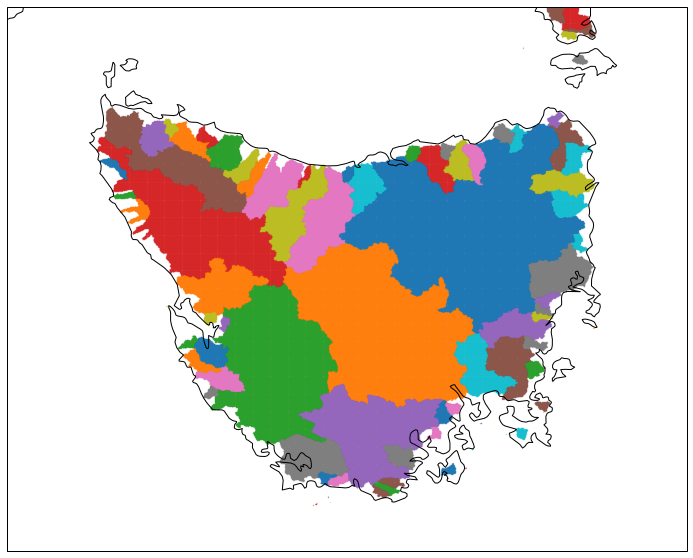

In [20]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=30)

for i in range(0,100):
    ax.scatter(xs[catch[i]], ys[catch[i]], s=0.05, alpha=0.5)

# plt.imshow(flows3, extent=map_extent, transform=ccrs.PlateCarree(),
#            cmap='Blues', origin='upper', vmin=-3.5, vmax=-2.5, alpha=1.0, zorder=10)

plt.savefig("WEx4-100Catchments-only.png", dpi=500)

In [92]:
catch_img = np.zeros_like(height)
catch_img[point_mask] = catchments.data
catch_norm = matplotlib.colors.Normalize(vmin=0.0, vmax=5.0)

logflow = np.log10(1.0e-3+upstream_area3)
flows_img = logflow.min() * np.ones_like(height)
flows_img[point_mask] = logflow
flows_norm = matplotlib.colors.Normalize(vmin=-3.0, vmax=-2.5)

In [93]:
logflow.max()

0.08413295044448676


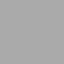

'WEx4-3DFlowpathsCatchments.png'

In [105]:

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=4.0)
im = (0.5+0.5*cm.Greys_r(catch_norm(catch_img%5.0))) * (0.2+0.8*cm.Blues(flows_norm(flows_img)))
im[..., 0:3][~point_mask] = (0.8,0.9,1.0)

import lavavu

points = np.column_stack([mesh.tri.points, 0.05*mesh.topography.data])

low_point_coords3 = points[low_points3]
outflow_point_coords3 = points[outflow_points3]

low_point_coords1 = points[low_points1]

lv = lavavu.Viewer(border=False, background=(0.8,0.9,1.0), resolution=[1200,600], near=-10.0, axis=False)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.texture(im)

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()



In [106]:
lv.image(filename="WEx4-3DFlowpathsCatchments.png", resolution=(3000,1500), quality=100)

'WEx4-3DFlowpathsCatchments.png'